In [1]:
import os 
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [2]:
#import the data 
os.chdir("./data")

def read_data(file_name):
    labels = []
    titles = []
    
    with open(file_name, 'r') as f:
        try:
            for line in f:
                if 'BillID,' in line:
                    pass
                elif '"' in line:
                    split_1 = line.split('"')
                    label = split_1[-1].lstrip(",").rstrip("\n")
                    labels.append(int(label))
                    title = split_1[-2].lstrip(",")
                    title = title.replace(",", "") #here I deleted "," from the titles.
                    titles.append(title)

                else:
                    split = line.split(",")
                    titles.append(split[-2])
                    labels.append(int(split[-1].strip("\n")))
        except:
            print(line)
                
    return ((titles, labels))

train_titles_raw, train_labels_raw = read_data("congress_train.csv")
val_titles_raw, val_labels_raw = read_data("congress_val.csv")
test_titles_raw, test_labels_raw = read_data("congress_test.csv")

114-HR-4322,4322,"To clarify the prohibition on affiliation under the Mentor-Protege Program of the Department of Defense, to amend the Small Business Act to improve cooperation between the mentor-protege programs of the Small Business Administration and the Department of Defense, and for other purposes.",15



In [3]:
#check the data length 

print (len(train_titles_raw), len(train_labels_raw))
print (len(val_titles_raw), len(val_labels_raw))
print (len(test_titles_raw), len(test_labels_raw))

274482 274482
69649 69649
38693 38693


In [4]:
#setting up_data
def setting_data(text_lst,maxlen, max_words):
    maxlen = maxlen
    max_words = max_words

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(text_lst)
    sequences = tokenizer.texts_to_sequences(text_lst)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=maxlen)

    print('Shape of data tensor:', data.shape)
    return (data)

In [5]:
#preprocessing train data 
x_train = setting_data(train_titles_raw, 
                       maxlen = 100,
                       max_words = 10000)

y_train = to_categorical(train_labels_raw)

#preprocessing validation data 
x_val = setting_data(val_titles_raw, 
                     maxlen = 100, 
                     max_words = 10000)

y_val = to_categorical(val_labels_raw)

#preprocessing test data 
x_test = setting_data(test_titles_raw, 
                      maxlen = 100,
                      max_words = 10000)

y_test = to_categorical(test_labels_raw)

Found 42197 unique tokens.
Shape of data tensor: (274482, 100)
Found 24985 unique tokens.
Shape of data tensor: (69649, 100)
Found 19813 unique tokens.
Shape of data tensor: (38693, 100)


In [6]:
len(y_train[0])

24

### Estimate a basic feed-forward network

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

maxlen = 100

basic_model = Sequential()

# output dim = 8
basic_model.add(Embedding(10000, 32, input_length = maxlen))
basic_model.add(Flatten())
basic_model.add(Dense(24, activation='softmax'))

basic_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
basic_model.summary()

history = basic_model.fit(x_train, y_train, epochs= 20, batch_size= 2048,
                         validation_data = (x_val, y_val))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                76824     
Total params: 396,824
Trainable params: 396,824
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 274482 samples, validate on 69649 samples
Epoch 1/20
274482/274482 [==============================] - 3s 11us/step - loss: 2.4610 - acc: 0.3088 - val_loss: 2.6319 - val_acc: 0.2294
Epoch 2/20
274482/274482 [==============================] - 2s 6us/step - loss: 1.4669 - a

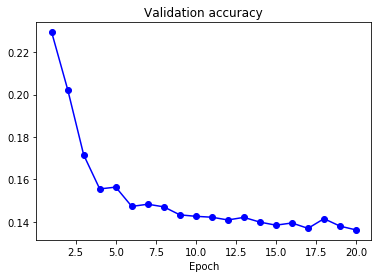

<Figure size 432x288 with 0 Axes>

In [8]:
basic_val_acc = history.history['val_acc']
basic_val_loss = history.history['val_loss']

epochs = range(1, len(basic_val_acc) + 1)

plt.plot(epochs, basic_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

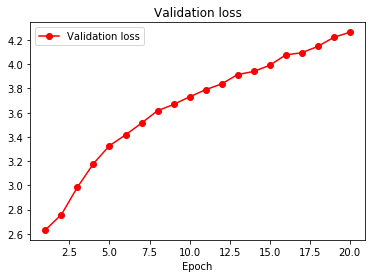

In [9]:
plt.clf()
plt.plot(epochs, basic_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate a recurrent neural network (RNN) with a layer_simple_rnn

In [10]:
from keras.layers import SimpleRNN

maxlen = 100

simple_rnn = Sequential()
simple_rnn.add(Embedding(10000, 32, input_length = maxlen))
simple_rnn.add(SimpleRNN(32))
simple_rnn.add(Dense(24, activation='softmax'))

simple_rnn.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
simple_rnn.summary()

rnn_history = simple_rnn.fit(x_train, y_train, epochs= 20, batch_size= 2048,
                         validation_data = (x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
Total params: 322,872
Trainable params: 322,872
Non-trainable params: 0
_________________________________________________________________
Train on 274482 samples, validate on 69649 samples
Epoch 1/20
274482/274482 [==============================] - 13s 46us/step - loss: 2.6269 - acc: 0.2373 - val_loss: 3.0273 - val_acc: 0.1403
Epoch 2/20
274482/274482 [==============================] - 12s 45us/step - loss: 1.9485 - acc: 0.4526 - val_loss: 3.5540 - val_acc: 0.1088
Epoch 3/20
274482/274482 [==============================] - 12s 44us/

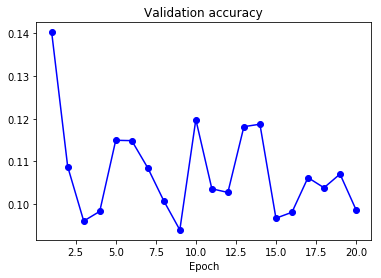

<Figure size 432x288 with 0 Axes>

In [11]:
rnn_val_acc = rnn_history.history['val_acc']
rnn_val_loss = rnn_history.history['val_loss']

epochs = range(1, len(rnn_val_acc) + 1)

plt.plot(epochs, rnn_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

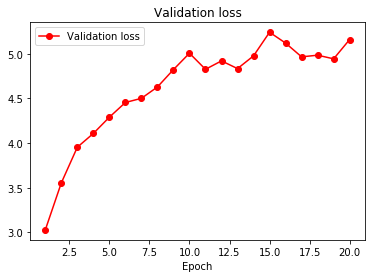

In [12]:
plt.clf()
plt.plot(epochs, rnn_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate an RNN with an LSTM layer

In [13]:
from keras.layers import LSTM

maxlen = 100

rnn_lstm = Sequential()
rnn_lstm.add(Embedding(10000, 32, input_length = maxlen))
rnn_lstm.add(LSTM(32))
rnn_lstm.add(Dense(24, activation='softmax'))

rnn_lstm.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
rnn_lstm.summary()

lstm_history = rnn_lstm.fit(x_train, y_train, epochs= 20, batch_size= 2048,
                         validation_data = (x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
Total params: 329,112
Trainable params: 329,112
Non-trainable params: 0
_________________________________________________________________
Train on 274482 samples, validate on 69649 samples
Epoch 1/20
274482/274482 [==============================] - 33s 120us/step - loss: 2.6673 - acc: 0.1966 - val_loss: 3.1453 - val_acc: 0.1150
Epoch 2/20
274482/274482 [==============================] - 32s 116us/step - loss: 2.0492 - acc: 0.4287 - val_loss: 3.1288 - val_acc: 0.1278
Epoch 3/20
274482/274482 [==============================] - 32s 116

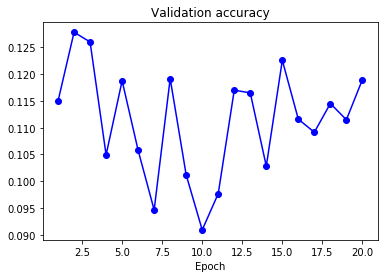

<Figure size 432x288 with 0 Axes>

In [14]:
lstm_val_acc = lstm_history.history['val_acc']
lstm_val_loss = lstm_history.history['val_loss']

epochs = range(1, len(lstm_val_acc) + 1)

plt.plot(epochs, lstm_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

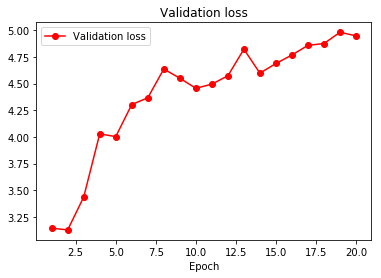

In [15]:
plt.clf()
plt.plot(epochs, lstm_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate an RNN with a GRU layer

In [18]:
from keras.layers import GRU

maxlen = 100

gru = Sequential()
gru.add(Embedding(10000, 32, input_length = maxlen))
gru.add(GRU(32))
gru.add(Dense(24, activation='softmax'))

gru.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
gru.summary()

gru_history = gru.fit(x_train, y_train, epochs= 20, batch_size= 2048,
                         validation_data = (x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                792       
Total params: 327,032
Trainable params: 327,032
Non-trainable params: 0
_________________________________________________________________
Train on 274482 samples, validate on 69649 samples
Epoch 1/20
274482/274482 [==============================] - 27s 97us/step - loss: 2.7474 - acc: 0.1676 - val_loss: 2.9559 - val_acc: 0.1299
Epoch 2/20
274482/274482 [==============================] - 26s 94us/step - loss: 2.3367 - acc: 0.3158 - val_loss: 3.2647 - val_acc: 0.0968
Epoch 3/20
274482/274482 [==============================] - 26s 94us/

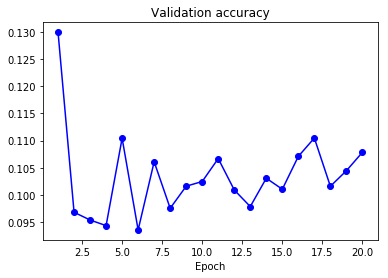

<Figure size 432x288 with 0 Axes>

In [19]:
gru_val_acc = gru_history.history['val_acc']
gru_val_loss = gru_history.history['val_loss']

epochs = range(1, len(gru_val_acc) + 1)

plt.plot(epochs, gru_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

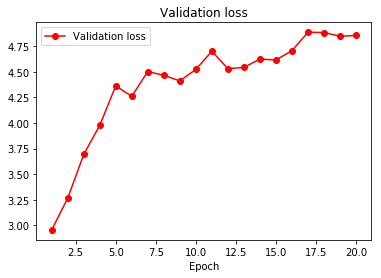

In [20]:
plt.clf()
plt.plot(epochs, gru_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()